[✓] Rerun with updated EmotiW dataset

[✓] Rerun with corrected file order

### ResNet-ResNet-LSTM
- ResNet-ResNet-50 (standard)
- LSTM

The idea here comes from how if ResNet+LSTM did fairly well, what happens if we ensembled more than one ResNet+LSTM model together?

**Best Model - Val Loss: (ResNet-LSTMx3-concat):**



**Best Model - Val Acc: (ResNet-LSTMx2-add):**



In [1]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/train_frames.tar.gz' .

In [0]:
!tar -xzf train_frames.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/val_frames.tar.gz' .
!tar -xzf val_frames.tar.gz

In [6]:
!ls

drive	     train_frames	  val_frames
sample_data  train_frames.tar.gz  val_frames.tar.gz


In [7]:
!nvidia-smi

Mon Jun  1 05:14:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join

class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames
    """
    def __init__(self, dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[k] = sorted(video_map[k], key=lambda x: x.split(".mp4_")[0] + x.split(".mp4_")[1].split(".jpg")[0].zfill(3))
                if min_frames == -1 or len(video_map[k]) < min_frames:
                    min_frames = len(video_map[k])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]

        # print(f"Working on batch {index} with {len(video_names)} videos")

        num_frames = self.min_frames if self.frames_to_use == -1 else self.frames_to_use
        X = np.zeros((len(video_names), num_frames, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
        y = []
        i = 0
        for vid in video_names:
            # print(vid)
            j = 0
            for frame in self.video_map[vid]:
                # print("   " + frame)
                frame_path = join(join(self.dir, self.video_to_class[vid]), frame)
                img = cv2.imread(frame_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Assume resized already
                # img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
                # print(img[0])
                X[i, j, :, :, :] = img
                j += 1
                if j >= num_frames:
                    break

            y.append(int(self.video_to_class[vid]) - 1)
            # print(f"{vid} - {int(self.video_to_class[vid]) - 1}")
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        # print("on_epoch_end")
        if self.shuffle == True:
            np.random.shuffle(self.video_names)




In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm"

In [10]:
train_generator = DataGenerator("train_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)

X, y = train_generator.__getitem__(0)


Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


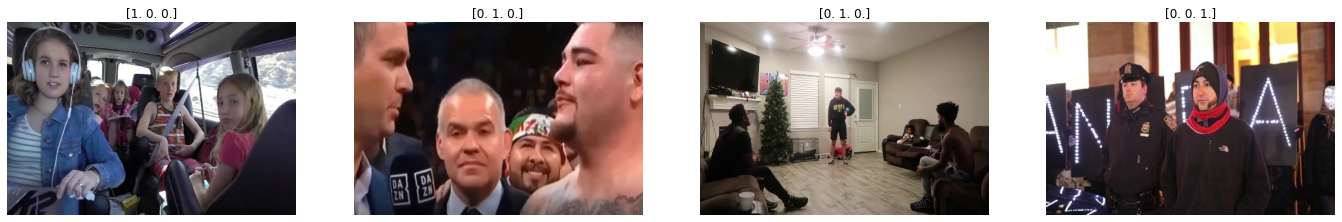

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(4):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n, 0])
          plt.title(label_batch[n])
          plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(1)
show_batch(image_batch, label_batch)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


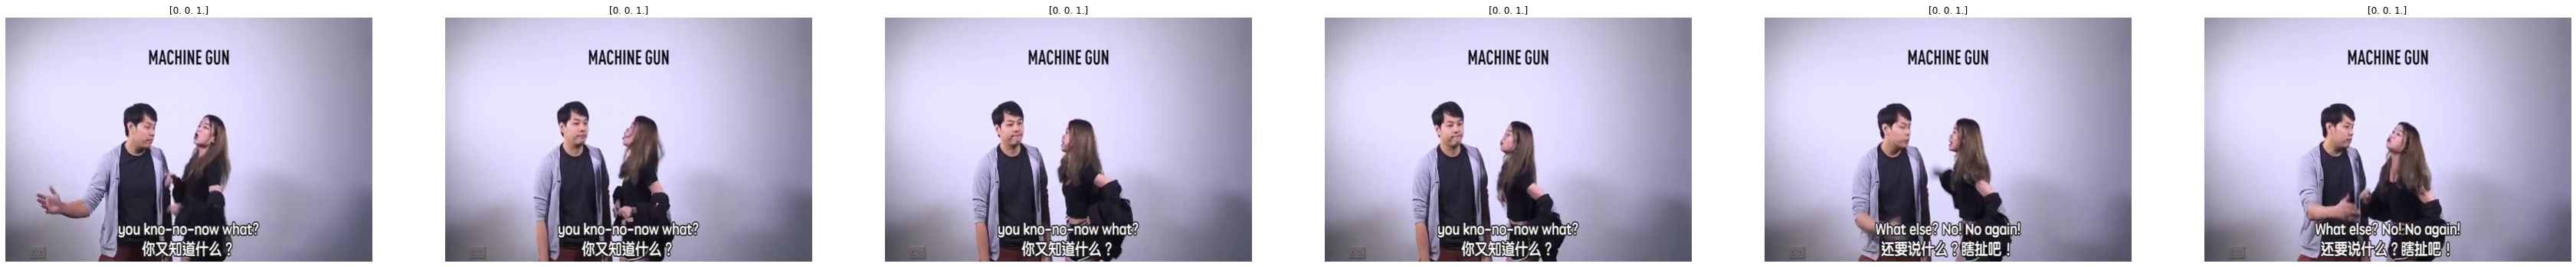

In [12]:
def show_frames_batch(image_batch, label_batch):
    plt.figure(figsize=(60,60))
    for n in range(6):
        ax = plt.subplot(1,6,n+1)
        plt.imshow(image_batch[0, n])
        plt.title(label_batch[0])
        plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(0)
show_frames_batch(image_batch, label_batch)

In [17]:
from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False
    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)

    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x = tf.keras.layers.Add()([x1, x2])
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_3[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, 12, 10, 15, 4 3006880     time_distributed_1[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)     (None, 12, 10, 15, 4 3006880     time_distributed_1[0][0]         
____________________________________________________________________________________________

In [18]:
# Try evaluating the model for a few rounds
loss0, accuracy0 = model.evaluate(validation_generator, steps = 3)

3/3 [==============================] - 1s 252ms/step - loss: 1.0846 - accuracy: 0.5000


In [19]:
validation_generator.batch_size

6

In [20]:
import pickle
history = model.fit(
          train_generator,
          epochs=10,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

Epoch 1/10
443/443 [==============================] - ETA: 0s - loss: 1.0510 - accuracy: 0.5361
Epoch 00001: val_loss improved from inf to 0.98982, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm/cp-0001.h5
443/443 [==============================] - 277s 625ms/step - loss: 1.0510 - accuracy: 0.5361 - val_loss: 0.9898 - val_accuracy: 0.5499
Epoch 2/10
443/443 [==============================] - ETA: 0s - loss: 0.8254 - accuracy: 0.6701
Epoch 00002: val_loss improved from 0.98982 to 0.98272, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm/cp-0002.h5
443/443 [==============================] - 268s 606ms/step - loss: 0.8254 - accuracy: 0.6701 - val_loss: 0.9827 - val_accuracy: 0.5630
Epoch 3/10
443/443 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7201
Epoch 00003: val_loss improved from 0.98272 to 0.90881, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm/cp-0003.h5
443/443 [==============================] - 272s 614ms/step 

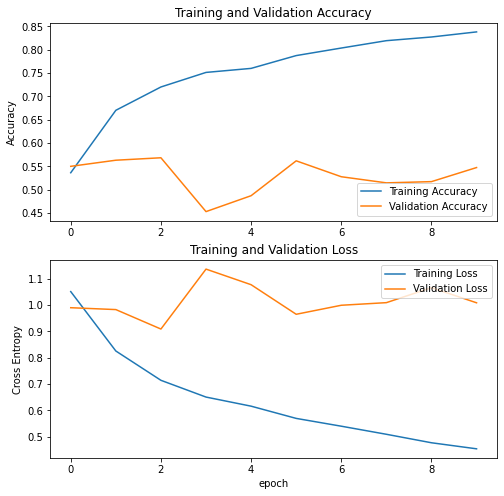

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



#### Let's try using concat instead of add

In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm.2"

In [23]:
from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False

    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x = tf.keras.layers.Concatenate()([x1, x2])
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_5[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)     (None, 12, 10, 15, 4 3006880     time_distributed_2[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)     (None, 12, 10, 15, 4 3006880     time_distributed_2[0][0]         
____________________________________________________________________________________________

In [24]:
import pickle
history = model.fit(
          train_generator,
          epochs=5,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)


Epoch 1/5
443/443 [==============================] - ETA: 0s - loss: 0.9655 - accuracy: 0.5591
Epoch 00001: val_loss improved from inf to 1.01522, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.2/cp-0001.h5
443/443 [==============================] - 273s 617ms/step - loss: 0.9655 - accuracy: 0.5591 - val_loss: 1.0152 - val_accuracy: 0.5066
Epoch 2/5
443/443 [==============================] - ETA: 0s - loss: 0.7862 - accuracy: 0.6614
Epoch 00002: val_loss improved from 1.01522 to 0.96248, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.2/cp-0002.h5
443/443 [==============================] - 271s 612ms/step - loss: 0.7862 - accuracy: 0.6614 - val_loss: 0.9625 - val_accuracy: 0.5171
Epoch 3/5
443/443 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.7197
Epoch 00003: val_loss did not improve from 0.96248
443/443 [==============================] - 270s 609ms/step - loss: 0.6903 - accuracy: 0.7197 - val_loss: 1.0262 - val_accuracy: 0.4816
E

### Let's try with more parallel layers?

In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm.3"

In [26]:
from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False

    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x3 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x3 = tf.keras.layers.GlobalAveragePooling3D()(x3)

    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_7[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)     (None, 12, 10, 15, 4 3006880     time_distributed_3[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)     (None, 12, 10, 15, 4 3006880     time_distributed_3[0][0]         
____________________________________________________________________________________________

In [27]:
import pickle
history = model.fit(
          train_generator,
          epochs=10,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)


Epoch 1/10
443/443 [==============================] - ETA: 0s - loss: 0.9332 - accuracy: 0.5745
Epoch 00001: val_loss improved from inf to 1.13977, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.3/cp-0001.h5
443/443 [==============================] - 323s 728ms/step - loss: 0.9332 - accuracy: 0.5745 - val_loss: 1.1398 - val_accuracy: 0.4199
Epoch 2/10
443/443 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.6915
Epoch 00002: val_loss improved from 1.13977 to 0.93793, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.3/cp-0002.h5
443/443 [==============================] - 321s 724ms/step - loss: 0.7477 - accuracy: 0.6915 - val_loss: 0.9379 - val_accuracy: 0.5499
Epoch 3/10
443/443 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7299
Epoch 00003: val_loss improved from 0.93793 to 0.93770, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.3/cp-0003.h5
443/443 [==============================] - 321s 725ms

### Remove all regularization

In [28]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm.4"



from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False

    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x3 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x3 = tf.keras.layers.GlobalAveragePooling3D()(x3)

    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_9[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)     (None, 12, 10, 15, 4 3006880     time_distributed_4[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D)    (None, 12, 10, 15, 4 3006880     time_distributed_4[0][0]         
____________________________________________________________________________________________

Epoch 1/5
443/443 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.5598
Epoch 00001: val_loss improved from inf to 0.99458, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.4/cp-0001.h5
443/443 [==============================] - 319s 721ms/step - loss: 0.9510 - accuracy: 0.5598 - val_loss: 0.9946 - val_accuracy: 0.5039
Epoch 2/5
443/443 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.6934
Epoch 00002: val_loss improved from 0.99458 to 0.92352, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.4/cp-0002.h5
443/443 [==============================] - 318s 717ms/step - loss: 0.7304 - accuracy: 0.6934 - val_loss: 0.9235 - val_accuracy: 0.5105
Epoch 3/5
443/443 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.7393
Epoch 00003: val_loss improved from 0.92352 to 0.89470, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.4/cp-0003.h5
443/443 [==============================] - 318s 718ms/st

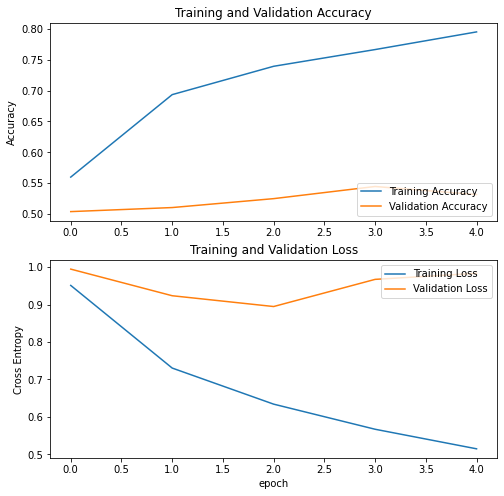

In [29]:
import pickle
history = model.fit(
          train_generator,
          epochs=5,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Add little bit of regularization

In [30]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm.5"



from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False

    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x3 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x3 = tf.keras.layers.GlobalAveragePooling3D()(x3)

    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_11[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_12 (ConvLSTM2D)    (None, 12, 10, 15, 4 3006880     time_distributed_5[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D)    (None, 12, 10, 15, 4 3006880     time_distributed_5[0][0]         
____________________________________________________________________________________________

Epoch 1/10
443/443 [==============================] - ETA: 0s - loss: 0.9256 - accuracy: 0.5677
Epoch 00001: val_loss improved from inf to 0.92765, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.5/cp-0001.h5
443/443 [==============================] - 321s 725ms/step - loss: 0.9256 - accuracy: 0.5677 - val_loss: 0.9277 - val_accuracy: 0.5486
Epoch 2/10
443/443 [==============================] - ETA: 0s - loss: 0.7358 - accuracy: 0.6892
Epoch 00002: val_loss did not improve from 0.92765
443/443 [==============================] - 323s 728ms/step - loss: 0.7358 - accuracy: 0.6892 - val_loss: 0.9504 - val_accuracy: 0.5210
Epoch 3/10
443/443 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7430
Epoch 00003: val_loss did not improve from 0.92765
443/443 [==============================] - 321s 724ms/step - loss: 0.6499 - accuracy: 0.7430 - val_loss: 0.9573 - val_accuracy: 0.5052
Epoch 4/10
443/443 [==============================] - ETA: 0s - loss: 0.5957 -

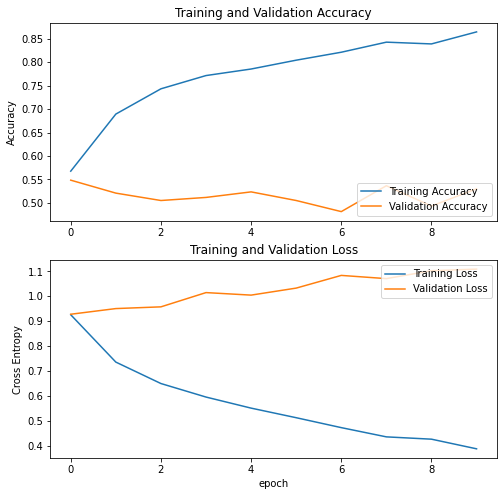

In [31]:
import pickle
history = model.fit(
          train_generator,
          epochs=10,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [32]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm.6"



from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False

    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x3 = tf.keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x3 = tf.keras.layers.GlobalAveragePooling3D()(x3)

    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_13[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_15 (ConvLSTM2D)    (None, 12, 10, 15, 4 3006880     time_distributed_6[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D)    (None, 12, 10, 15, 4 3006880     time_distributed_6[0][0]         
____________________________________________________________________________________________

Epoch 1/10
443/443 [==============================] - ETA: 0s - loss: 0.9050 - accuracy: 0.5907
Epoch 00001: val_loss improved from inf to 1.00596, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.6/cp-0001.h5
443/443 [==============================] - 318s 719ms/step - loss: 0.9050 - accuracy: 0.5907 - val_loss: 1.0060 - val_accuracy: 0.5066
Epoch 2/10
443/443 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7013
Epoch 00002: val_loss did not improve from 1.00596
443/443 [==============================] - 316s 713ms/step - loss: 0.7117 - accuracy: 0.7013 - val_loss: 1.0656 - val_accuracy: 0.4659
Epoch 3/10
443/443 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.7521
Epoch 00003: val_loss improved from 1.00596 to 0.94220, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.6/cp-0003.h5
443/443 [==============================] - 316s 713ms/step - loss: 0.6169 - accuracy: 0.7521 - val_loss: 0.9422 - val_accuracy: 0.515

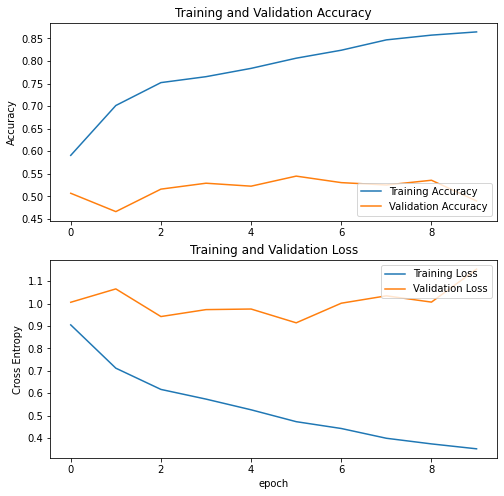

In [33]:
import pickle
history = model.fit(
          train_generator,
          epochs=10,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [0]:
from pathlib import Path


IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm.7"

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)

def create_model(inputs, num_filters):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False

    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=num_filters, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=num_filters, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x3 = tf.keras.layers.ConvLSTM2D(filters=num_filters, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x3 = tf.keras.layers.GlobalAveragePooling3D()(x3)

    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))

def get_callback_fn(num_filters):
    checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/convlstmfilters-" + str(num_filters) + "-cp-{epoch:04d}.h5"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_weights_only=False,
        save_best_only=True,
        period=1)
    return cp_callback


In [35]:
import pickle
import numpy as np

candidate_filters = np.arange(10, 60, 10)
best_history_loss = None
best_loss = 10
best_loss_filters = None

for filters in candidate_filters:
    print("")
    print("")
    print("-----------------------------------")
    print(f"Training model with {filters} filters")

    model = create_model(inputs, filters)
    history = model.fit(
              train_generator,
              epochs=5,
              callbacks=[get_callback_fn(filters)],
              validation_data=validation_generator
    )

    best_loss_model = min(history.history["val_loss"])

    if best_history_loss is None or best_loss > best_loss_model:
        best_history_loss = history.history
        best_loss_filters = filters
        best_loss = best_loss_model

print("===")
print(f"Best loss achieved: {best_loss} with {best_loss_filters} filters")
print(f"Best acc achieved: {best_acc} with {best_acc_filters} filters")

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/v1-history-bestloss.pkl", 'wb') as handle:
    pickle.dump(best_history_loss, handle)




-----------------------------------
Training model with 10 filters
Epoch 1/5
443/443 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.5685
Epoch 00001: val_loss improved from inf to 0.94143, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.7/convlstmfilters-10-cp-0001.h5
443/443 [==============================] - 311s 702ms/step - loss: 0.9302 - accuracy: 0.5685 - val_loss: 0.9414 - val_accuracy: 0.5407
Epoch 2/5
443/443 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.6817
Epoch 00002: val_loss improved from 0.94143 to 0.87193, saving model to drive/My Drive/checkpoints/resnet-resnet-lstm.7/convlstmfilters-10-cp-0002.h5
443/443 [==============================] - 307s 693ms/step - loss: 0.7477 - accuracy: 0.6817 - val_loss: 0.8719 - val_accuracy: 0.5472
Epoch 3/5
443/443 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7318
Epoch 00003: val_loss did not improve from 0.87193
443/443 [====================

NameError: ignored

### Take updated model and upload to GCS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from google.colab import auth
auth.authenticate_user()
project_id = 'calm-depot-274104'
!gcloud config set project {project_id}
!gsutil ls



Updated property [core/project].
gs://cs231n-emotiw/


In [3]:

!gsutil -m cp -r drive/My\ Drive/checkpoints/resnet-resnet-lstm.7/convlstmfilters-10-cp-0002.h5 gs://cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5

Copying file://drive/My Drive/checkpoints/resnet-resnet-lstm.7/convlstmfilters-10-cp-0002.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/115.8 MiB.                                    


### Saliency and grad-CAM

Based on https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

In [0]:
!pip install tf-keras-vis

In [0]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
from tf_keras_vis.utils import print_gpus

print_gpus()

In [0]:
import tensorflow as tf
model = tf.keras.models.load_model("drive/My Drive/checkpoints/resnet-resnet-lstm.7/m1.h5")
model.summary()

In [0]:
!ls train_frames/3/ | tail -100

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tf_keras_vis import ModelVisualization
from tf_keras_vis.utils import check_steps, listify

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

# Adapted from https://github.com/keisen/tf-keras-vis/blob/master/tf_keras_vis/saliency.py
class CustomSaliency(ModelVisualization):
    def __call__(self,
                 seed_input,
                 label,
                 smooth_samples=0,
                 smooth_noise=0.20,
                 keepdims=False,
                 gradient_modifier=lambda grads: K.abs(grads)):
        """Generate an attention map that appears how output value changes with respect to a small
            change in input image pixels.
            See details: https://arxiv.org/pdf/1706.03825.pdf
        # Arguments
            seed_input: An N-dim Numpy array. If the model has multiple inputs,
                you have to pass a list of N-dim Numpy arrays.
            smooth_samples: The number of calculating gradients iterations. If set to zero,
                the noise for smoothing won't be generated.
            keepdims: A boolean that whether to keep the channels-dim or not.
            smooth_noise: Noise level that is recommended no tweaking when there is no reason.
            gradient_modifier: A function to modify gradients. By default, the function modify
                gradients to `absolute` values.
        # Returns
            The heatmap image indicating the `seed_input` regions whose change would most contribute
            towards maximizing the loss value, Or a list of their images.
            A list of Numpy arrays that the model inputs that maximize the out of `loss`.
        # Raises
            ValueError: In case of invalid arguments for `loss`, or `seed_input`.
        """
        # Preparing
        seed_inputs = tf.convert_to_tensor(seed_input, dtype=tf.float32)
        # Processing saliency
        if smooth_samples > 0:
            axis = tuple(range(1, len(seed_inputs.shape)))
            sigmas = smooth_noise * (np.max(seed_inputs, axis=axis) - np.min(seed_inputs, axis=axis))
            total_gradients = np.zeros_like(seed_inputs)
            for i in range(check_steps(smooth_samples)):
                print(f"Running step {i}")
                seed_inputs_plus_noise = tf.constant(
                        np.concatenate([
                            x + np.random.normal(0., s, (1, ) + x.shape) for x, s in zip(seed_inputs, sigmas)
                        ])
                )

                gradients = self._get_gradients(seed_inputs_plus_noise, gradient_modifier, label)
                total_gradients = total_gradients + gradients[0]
            grads = total_gradients / smooth_samples
        else:
            grads = self._get_gradients(seed_inputs, gradient_modifier, label)

        # Visualizing
        if not keepdims:
            grads = [np.max(g, axis=-1) for g in grads]
        if len(self.model.inputs) == 1 and not isinstance(seed_input, list):
            grads = grads[0]
        return grads

    # Define loss function. 
    def loss(self, output, label):
        # 0 is positive, 1 is neutral, 2 is negative
        return (output[0, label - 1])

    def _get_gradients(self, seed_inputs, gradient_modifier, label):
        with tf.GradientTape() as tape:
            tape.watch(seed_inputs)
            outputs = self.model(seed_inputs)
            loss_values = self.loss(outputs, label)
            grads = tape.gradient(loss_values, seed_inputs)
        if gradient_modifier is not None:
            grads = [gradient_modifier(g) for g in grads]
        return grads

In [0]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

def render_saliency_map(root_folder, label, file_name):
    selected_files = []
    selected_images = []
    selected_labels = []
    files = next(os.walk(f"{root_folder}/{label}/"))[2]

    for file in files:
        if "_" + file_name in file:
            selected_files.append(file)
            categories = [0, 0, 0]
            categories[label - 1] = 1
            selected_labels.append(categories)

    for i, file in enumerate(sorted(selected_files)):
        if i >= 12:
            break

        img = cv2.imread(f"{root_folder}/{label}/{file}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        selected_images.append(img)
    selected_images = np.array(selected_images)

    X = np.expand_dims(selected_images, axis=0)

    # Create Saliency object
    saliency = CustomSaliency(model, model_modifier, clone=False)

    # Generate saliency map
    saliency_map = saliency(X, label, smooth_samples=10)
    saliency_map = normalize(saliency_map)

    subprot_args = {
        'nrows': 2,
        'ncols': 12,
        'figsize': (24, 3),
        'subplot_kw': {'xticks': [], 'yticks': []}
    }

    f, ax = plt.subplots(**subprot_args)
    for i in range(len(saliency_map)):
        ax[0, i].imshow(selected_images[i])
        ax[1, i].imshow(saliency_map[i], cmap='jet')
    plt.tight_layout()
    plt.show()


    subprot_args = {
        'nrows': 1,
        'ncols': 12,
        'figsize': (24, 3),
        'subplot_kw': {'xticks': [], 'yticks': []}
    }
    f, ax = plt.subplots(**subprot_args)
    for i in range(len(saliency_map)):
        ax[i].imshow(selected_images[i])
        ax[i].imshow(saliency_map[i], cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [0]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

render_saliency_map("train_frames", 1, "9_15.mp4")



In [0]:

render_saliency_map("train_frames", 2, "9_9.mp4")


In [0]:

render_saliency_map("train_frames", 3, "97_7.mp4")


In [0]:
!nvidia-smi

### Retrain with the frame order corrected (see if it will make a big difference)

In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join

class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames
    """
    def __init__(self, dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[k] = sorted(video_map[k], key=lambda x: x.split(".mp4_")[0] + x.split(".mp4_")[1].split(".jpg")[0].zfill(3))
                if k == "frame_41_14":
                    print(video_map[k])
                if min_frames == -1 or len(video_map[k]) < min_frames:
                    min_frames = len(video_map[k])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]

        # print(f"Working on batch {index} with {len(video_names)} videos")

        num_frames = self.min_frames if self.frames_to_use == -1 else self.frames_to_use
        X = np.zeros((len(video_names), num_frames, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
        y = []
        i = 0
        for vid in video_names:
            # print(vid)
            j = 0
            for frame in self.video_map[vid]:
                # print("   " + frame)
                frame_path = join(join(self.dir, self.video_to_class[vid]), frame)
                img = cv2.imread(frame_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Assume resized already
                # img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
                # print(img[0])
                X[i, j, :, :, :] = img
                j += 1
                if j >= num_frames:
                    break

            y.append(int(self.video_to_class[vid]) - 1)
            # print(f"{vid} - {int(self.video_to_class[vid]) - 1}")
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        # print("on_epoch_end")
        if self.shuffle == True:
            np.random.shuffle(self.video_names)


train_generator = DataGenerator("train_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)

X, y = train_generator.__getitem__(0)


In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 12
BATCH_SIZE = 6
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-resnet-lstm.7.path"



from pathlib import Path

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    period=1)

def create_model(inputs):
    base_model1 = get_base_model(BASE_NAME)
    base_model1.trainable = False

    x0 = tf.keras.layers.TimeDistributed(base_model1)(inputs)
    x1 = tf.keras.layers.ConvLSTM2D(filters=50, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x1 = tf.keras.layers.GlobalAveragePooling3D()(x1)

    x2 = tf.keras.layers.ConvLSTM2D(filters=50, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x2 = tf.keras.layers.GlobalAveragePooling3D()(x2)

    x3 = tf.keras.layers.ConvLSTM2D(filters=50, kernel_size=(3, 3), padding='same', return_sequences=True)(x0)
    x3 = tf.keras.layers.GlobalAveragePooling3D()(x3)

    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
model = create_model(inputs)
model.summary()




In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=10,
          # callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [0]:
"frame_41_14.mp4_7.jpg".split(".mp4_")[0] + "frame_41_14.mp4_7.jpg".split(".mp4_")[1].split(".jpg")[0].zfill(3)

In [0]:
sorted(train_generator.find_samples()[1]["frame_41_14"])